In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import zipfile
local_zip = '/content/gdrive/MyDrive/Dataset_3.064.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')

Mounted at /content/gdrive


In [ ]:
import os
import cv2
import io
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from warnings import filterwarnings
from IPython.display import display,clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
for dirname, _, filenames in os.walk('/content/dataset'):
  for filename in filenames:
    (os.path.join(dirname, filename))

In [ ]:
labels = ['glioma', 'meningioma', 'pituitary']

# Data Preparation

In [ ]:
X_train = []
y_train = []
image_size = 200
for i in labels:
  folderPath = os.path.join('../content/dataset/Dataset_3.064',i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img)
    img = img.astype('float32')/255.0
    img = cv2.resize(img,(image_size, image_size))
    img = np.expand_dims(img, axis=-1)
    X_train.append(img)
    y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 930/930 [00:09<00:00, 93.94it/s]


In [ ]:
X_train.shape

(3064, 200, 200, 1)

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=2,
    height_shift_range=2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(3064, 200, 200, 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

print("Train:", X_train.shape,
      "\nTest:", X_test.shape,)

Train: (2451, 200, 200, 1) 
Test: (613, 200, 200, 1)


In [ ]:
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Train Model**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Conv1D, Add, Activation, Reshape
from tensorflow.keras import layers

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding="same")(inputs)
    x = Conv2D(num_filters, 3, activation='relu', padding="same")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

class StripPooling(layers.Layer):
    def __init__(self, pool_size, **kwargs):
        super(StripPooling, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.adaptive_pool1 = layers.Lambda(lambda x: tf.reduce_max(x, axis=1, keepdims=True))
        self.adaptive_pool2 = layers.Lambda(lambda x: tf.reduce_max(x, axis=2, keepdims=True))
        self.conv1d_1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")
        self.conv1d_2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")
        self.conv1d_3 = Conv2D(filters=128, kernel_size=1, activation='sigmoid', padding="same")
        self.add_1 = layers.Add()
        self.multiply = layers.Multiply()
        self.add_2 = layers.Add()
        self.relu = layers.ReLU()
        self.batch_norm = BatchNormalization()

    def call(self, inputs):
        pool1 = self.adaptive_pool1(inputs)
        pool2 = self.adaptive_pool2(inputs)

        conv1d_1_out = self.conv1d_1(pool1)
        conv1d_2_out = self.conv1d_2(pool2)

        expand1 = tf.expand_dims(conv1d_1_out, axis=2)
        expand2 = tf.expand_dims(conv1d_2_out, axis=1)

        fusion = self.add_1([expand1, expand2])

        conv1d_3_out = self.conv1d_3(fusion)

        multiply_out = self.multiply([inputs, conv1d_3_out])

        residual = self.add_2([inputs, multiply_out])

        out = self.relu(residual)
        out = self.batch_norm(out)

        return out

In [ ]:
def aspp(inputs):
    conv1 = Conv2D(64, kernel_size=3, strides=1, dilation_rate=1, padding='same')(inputs)
    bn1 = BatchNormalization()(conv1)
    relu1 = layers.ReLU()(bn1)

    # Block 2
    conv2 = Conv2D(64, kernel_size=3, strides=1, dilation_rate=3, padding='same')(inputs)
    bn2 = BatchNormalization()(conv2)
    relu2 = layers.ReLU()(bn2)

    # Block 3
    conv3 = Conv2D(64, kernel_size=3, strides=1, dilation_rate=5, padding='same')(inputs)
    bn3 = BatchNormalization()(conv3)
    relu3 = layers.ReLU()(bn3)

    # Block 4
    conv4 = Conv2D(256, kernel_size=1, strides=1)(inputs)
    bn4 = BatchNormalization()(conv4)
    relu4 = layers.ReLU()(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(inputs)

    # Block 5
    concatenated_features = concatenate([relu1, relu2, relu3, relu4, pool4], axis=-1)
    conv5 = Conv2D(512, kernel_size=1, strides=1)(concatenated_features)
    bn5 = BatchNormalization()(conv5)
    relu5 = layers.ReLU()(bn5)

    x = relu5

    return x

In [ ]:
def fcm(inputs, num_classes):
    # Fully connected layer 1
    x = Conv2D(filters=256, kernel_size=3)(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    # Fully connected layer 2
    x = Conv2D(filters=128, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    # Fully connected layer 3
    x = Conv2D(filters=num_classes, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)

    return x

In [ ]:
from tensorflow.keras import regularizers
#L2 regularization parameter
l2_reg = 0.0001

In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 128)
    s2, p2 = encoder_block(p1, 256)
    s3, p3 = encoder_block(p2, 512)
    b1 = conv_block(p3, 1024)
    d1 = decoder_block(b1, s3, 512)
    d2 = decoder_block(d1, s2, 256)
    d3 = decoder_block(d2, s1, 128)
    o1 = StripPooling(pool_size=(200, 200))(d3)
    o2 = tf.squeeze(o1, axis=1)
    o3 = aspp(o2)
    o4 = fcm(o3, 3)
    predictions = layers.Dense(3, kernel_regularizer=regularizers.l2(l2_reg), activation='softmax')(o4)

    model = Model(inputs=inputs, outputs=predictions)
    return model

In [ ]:
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
pool_size = (200,200)
input_shape=(height, width, channels)
model=build_model(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 12  1280        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 12  147584      ['conv2d[0][0]']                 
                                8)                                                            

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor=0.3, patience=2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()],
              weighted_metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs=150, verbose=1, batch_size=24,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/150
82/82 [==============================] - ETA: 0s - loss: 1.0472 - precision: 0.6142 - recall: 0.5393 - auc: 0.7706 - accuracy: 0.5811
Epoch 1: val_accuracy improved from -inf to 0.45621, saving model to effnet.h5
82/82 [==============================] - 597s 3s/step - loss: 1.0472 - precision: 0.6142 - recall: 0.5393 - auc: 0.7706 - accuracy: 0.5811 - val_loss: 3.5001 - val_precision: 0.4562 - val_recall: 0.4562 - val_auc: 0.5923 - val_accuracy: 0.4562 - lr: 1.0000e-04
Epoch 2/150
82/82 [==============================] - ETA: 0s - loss: 0.6727 - precision: 0.7523 - recall: 0.7005 - auc: 0.8868 - accuracy: 0.7291
Epoch 2: val_accuracy did not improve from 0.45621
82/82 [==============================] - 43s 519ms/step - loss: 0.6727 - precision: 0.7523 - recall: 0.7005 - auc: 0.8868 - accuracy: 0.7291 - val_loss: 8.9971 - val_precision: 0.4562 - val_recall: 0.4562 - val_auc: 0.5922 - val_accuracy: 0.4562 - lr: 1.0000e-04
Epoch 3/150
82/82 [==============================] - E

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

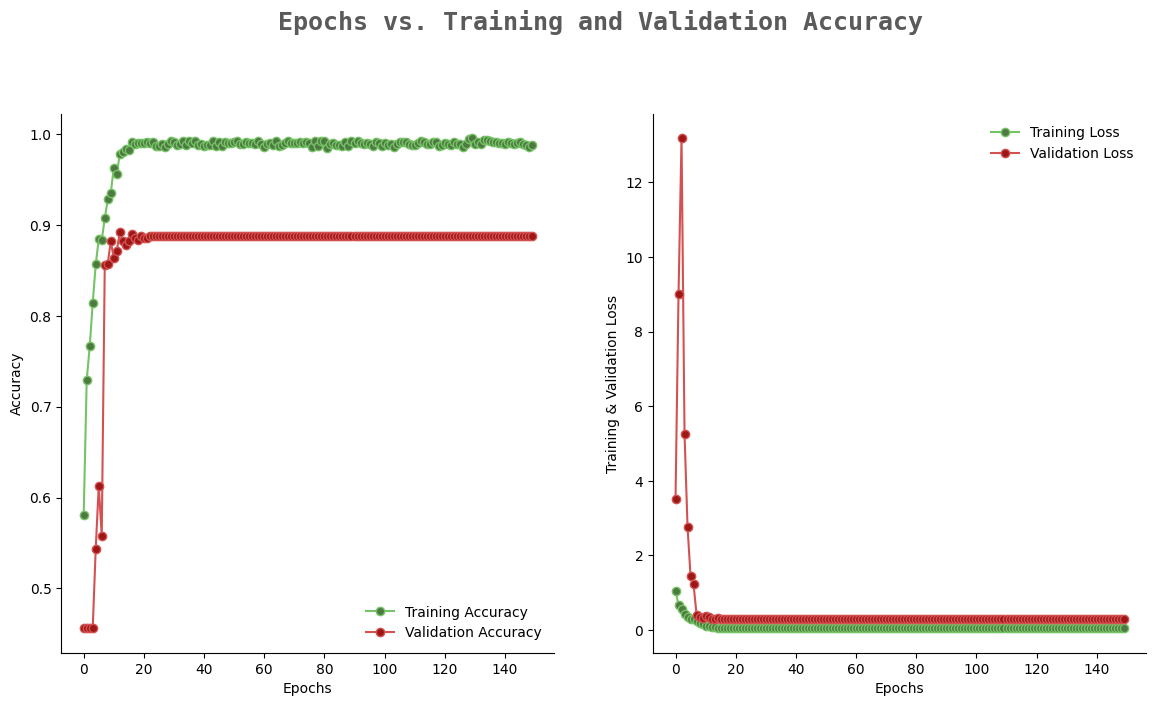

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(150)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

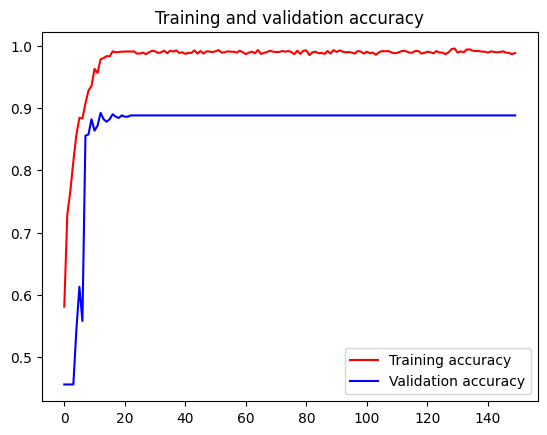

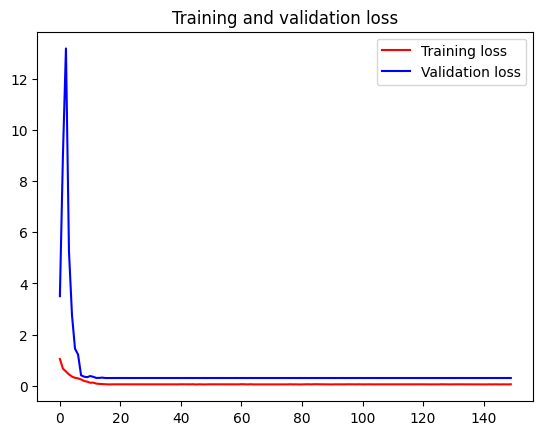

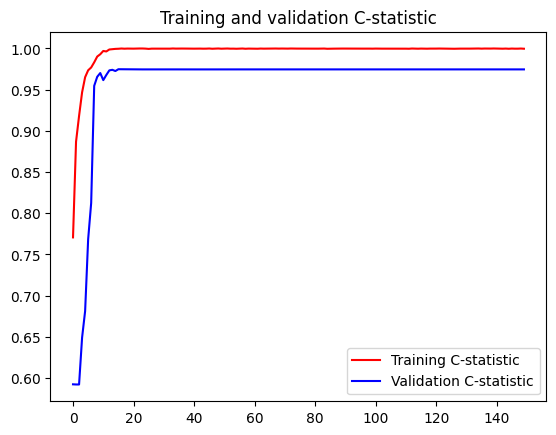

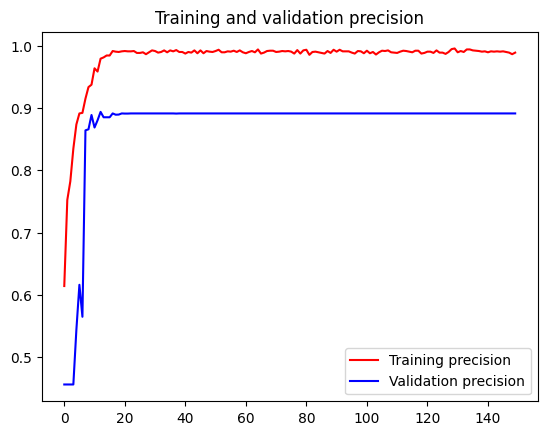

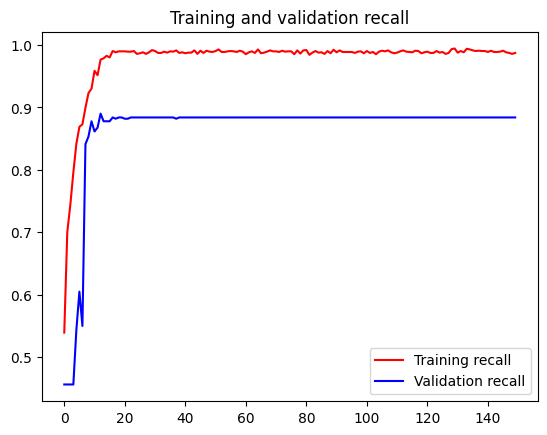

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history['auc']
val_auc = history.history['val_auc']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, auc, 'r', label='Training C-statistic')
plt.plot(epochs, val_auc, 'b', label='Validation C-statistic')
plt.title('Training and validation C-statistic')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.show()

In [ ]:
pred1 = model.predict(X_train)
pred1 = np.argmax(pred1,axis=1)
y_train_new = np.argmax(y_train,axis=1)

77/77 [==============================] - 35s 294ms/step


In [ ]:
print(classification_report(y_train_new,pred1))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1145
           1       0.96      0.97      0.97       562
           2       0.97      0.98      0.97       744

    accuracy                           0.98      2451
   macro avg       0.97      0.97      0.97      2451
weighted avg       0.98      0.98      0.98      2451



In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

20/20 [==============================] - 6s 321ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       281
           1       0.90      0.84      0.87       146
           2       0.89      0.92      0.91       186

    accuracy                           0.89       613
   macro avg       0.90      0.89      0.89       613
weighted avg       0.89      0.89      0.89       613



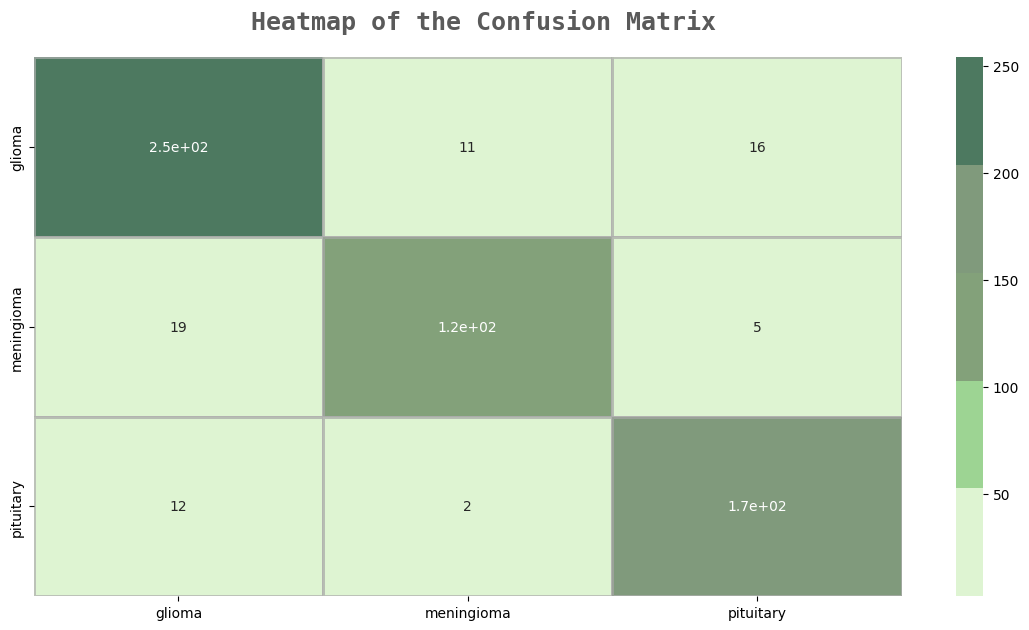

In [ ]:
import seaborn as sns

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
            cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix', size=18,fontweight='bold',
         fontname='monospace', color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()